# Fair HPO through Constrained Bayesian Optimization

Given the increasing importance of machine learning (ML) in our lives, with a wide use of automated systems in several domains, such as financial lending, hiring, criminal justice, and college admissions, there has been a major concern for ML to unintentionally encode societal biases and result in systematic discrimination. For example, a classifier that is only tuned to maximize prediction accuracy may unfairly predict a high credit risk for some subgroups of the population applying for a loan. 

In several real-world domains, accuracy is not the only objective of interest. The model should simultaneously give guarantees on other important aspects. Algorithmic fairness tries to find algorithms that not only keep a high level of accuracy but also enforce a certain level of fairness and avoid biases.

In this tutorial we are going to use the German Credit Data (1). This dataset contains a binary classification task, where the goal is to predict if a person has "good" or "bad" credit risk. The dataset contains 20 attributes, including a sensitive features such as the (binary) gender of the person. In the following we download, load and explore this dataset.

(1) Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


In [1]:
# AutoGluon and HPO tools
import autogluon.core as ag
import pandas as pd
import numpy as np
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Fixing seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

## Dataset setup and visualization

This code will automatically download the data from the UCI repository.
You can download the data manually from here: [UCI german lending dataset link.](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', header=None, sep=' ')
df.columns = ["CheckingAC_Status","MaturityMonths","CreditHistory","Purpose","LoanAmount","SavingsAC",
                  "Employment","InstalmentPctOfIncome","SexAndStatus","OtherDebts","PresentResidenceYears",
                  "Property","Age","OtherInstalmentPlans","Housing","NumExistingLoans","Job",
                  "Dependents","Telephone","ForeignWorker","Class1Good2Bad"]

We are now ready to preprocess the raw features as following:

In [3]:
df["target"] = df["Class1Good2Bad"].replace([1, 2], [1, 0]).astype("category")
df = df.drop(columns=["Class1Good2Bad"])
df["CheckingAC_Status"] = (
    df["CheckingAC_Status"]
    .replace(["A11", "A12", "A13", "A14"], ["x < 0 DM", "0 <= x < 200 DM", "x >= 200DM", "no checking account"])
    .astype("category")
)
df["CreditHistory"] = (
    df["CreditHistory"]
    .replace(
        ["A30", "A31", "A32", "A33", "A34"],
        ["no credits", "all credits paid", "existing credits paid", "delay", "critical accnt. / other credits"],
    )
    .astype("category")
)
df["Purpose"] = (
    df["Purpose"]
    .replace(
        ["A40", "A41", "A42", "A43", "A44", "A45", "A46", "A47", "A48", "A49", "A410"],
        [
            "new car",
            "used car",
            "forniture",
            "radio/tv",
            "appliances",
            "repairs",
            "education",
            "vacation",
            "retraining",
            "business",
            "others",
        ],
    )
    .astype("category")
)
df["SavingsAC"] = (
    df["SavingsAC"]
    .replace(
        ["A61", "A62", "A63", "A64", "A65"],
        ["x < 100 DM", "100 <= x < 500 DM", "500 <= x < 1000 DM", "x >= 1000 DM", "unknown"],
    )
    .astype("category")
)
df["Employment"] = (
    df["Employment"]
    .replace(
        ["A71", "A72", "A73", "A74", "A75"],
        ["unemployed", "x < 1 year", "1 <= x < 4 years", "4 <= x < 7 years", "x >= 7 years"],
    )
    .astype("category")
)
df["SexAndStatus"] = (
    df["SexAndStatus"]
    .replace(
        ["A91", "A92", "A93", "A94", "A95"],
        [
            "male divorced/separated",
            "female divorced/separated/married",
            "male single",
            "male married/widowed",
            "female single",
        ],
    )
    .astype("category")
)
df["OtherDebts"] = (
    df["OtherDebts"].replace(["A101", "A102", "A103"], ["none", "co-applicant", "guarantor"]).astype("category")
)
df["Property"] = (
    df["Property"]
    .replace(
        ["A121", "A122", "A123", "A124"],
        ["real estate", "soc. savings / life insurance", "car or other", "unknown"],
    )
    .astype("category")
)
df["OtherInstalmentPlans"] = (
    df["OtherInstalmentPlans"].replace(["A141", "A142", "A143"], ["bank", "stores", "none"]).astype("category")
)
df["Housing"] = df["Housing"].replace(["A151", "A152", "A153"], ["rent", "own", "for free"]).astype("category")
df["Job"] = (
    df["Job"]
    .replace(
        ["A171", "A172", "A173", "A174"],
        [
            "unemployed / unskilled-non-resident",
            "unskilled-resident",
            "skilled employee / official",
            "management / self-employed / highly qualified employee / officer",
        ],
    )
    .astype("category")
)
df["Telephone"] = df["Telephone"].replace(["A191", "A192"], ["none", "yes"]).astype("category")
df["ForeignWorker"] = df["ForeignWorker"].replace(["A201", "A202"], ["yes", "no"]).astype("category")

We can plot a few statistics to see if there is a risk of bias, due to unbalanced data or other facotrs. Let's begin with checking the data we laoded.

In [4]:
df

,CheckingAC_Status,MaturityMonths,CreditHistory,Purpose,LoanAmount,SavingsAC,Employment,InstalmentPctOfIncome,SexAndStatus,OtherDebts,...,Property,Age,OtherInstalmentPlans,Housing,NumExistingLoans,Job,Dependents,Telephone,ForeignWorker,target
0,x < 0 DM,6,critical accnt. / other credits,radio/tv,1169,unknown,x >= 7 years,4,male single,none,...,real estate,67,none,own,2,skilled employee / official,1,yes,yes,1
1,0 <= x < 200 DM,48,existing credits paid,radio/tv,5951,x < 100 DM,1 <= x < 4 years,2,female divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,0
2,no checking account,12,critical accnt. / other credits,education,2096,x < 100 DM,4 <= x < 7 years,2,male single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,1
3,x < 0 DM,42,existing credits paid,forniture,7882,x < 100 DM,4 <= x < 7 years,2,male single,guarantor,...,soc. savings / life insurance,45,none,for free,1,skilled employee / official,2,none,yes,1
4,x < 0 DM,24,delay,new car,4870,x < 100 DM,1 <= x < 4 years,3,male single,none,...,unknown,53,none,for free,2,skilled employee / official,2,none,yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paid,forniture,1736,x < 100 DM,4 <= x < 7 years,3,female divorced/separated/married,none,...,real estate,31,none,own,1,unskilled-resident,1,none,yes,1
996,x < 0 DM,30,existing credits paid,used car,3857,x < 100 DM,1 <= x < 4 years,4,male divorced/separated,none,...,soc. savings / life insurance,40,none,own,1,management / self-employed / highly qualified ...,1,yes,yes,1
997,no checking account,12,existing credits paid,radio/tv,804,x < 100 DM,x >= 7 years,4,male single,none,...,car or other,38,none,own,1,skilled employee / official,1,none,yes,1
998,x < 0 DM,45,existing credits paid,radio/tv,1845,x < 100 DM,1 <= x < 4 years,4,male single,none,...,unknown,23,none,for free,1,skilled employee / official,1,yes,yes,0


We can now plot the hisograms for:

(1) binary target output for good (1) or bad (0) credit risk;

(2) binary ForeignWorker feature;

(3) binary target output for individuals with ForeignWorker feature equals to "yes";

(4) binary target output for individuals with ForeignWorker feature equals to "no".

/Users/vperrone/workplace/amper_workspace/src/AutoGluon/core/autogluon_venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


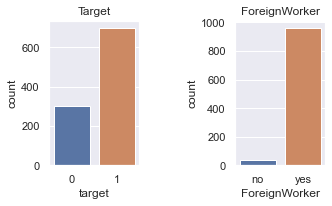

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout(pad=5.0)

sns.countplot(df['target'], ax=ax1)
ax1.set_title('Target')

sns.countplot(df['ForeignWorker'], ax=ax2)
ax2.set_title('ForeignWorker')
plt.show()

We can note that our dataset unbalanced, having more than double positive examples compared to negative ones. The unbalance is ever higher concerning the two subgroups of foreign against local workers.

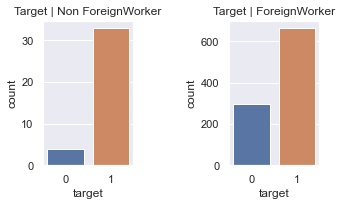

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout(pad=5.0)

sns.countplot(df[df["ForeignWorker"] == 'no']['target'], ax=ax1)
ax1.set_title('Target | Non ForeignWorker')


sns.countplot(df[df["ForeignWorker"] == 'yes']['target'], ax=ax2)
ax2.set_title('Target | ForeignWorker')
plt.show()

Finally, here we have a possible source of bias: the proportion between positive and negative target label is different between the two subgroups.

In [7]:
bad_credit_risk_foreign = 1.0 - np.array(df[df["ForeignWorker"] == 'yes']['target']).mean()
bad_credit_risk_local = 1.0 - np.array(df[df["ForeignWorker"] == 'no']['target']).mean()

print(f"Proportion of bad credit risk for foreign workers: {bad_credit_risk_foreign}")
print(f"Proportion of bad credit risk for non foreign workers: {bad_credit_risk_local}")

Proportion of bad credit risk for foreign workers: 0.3073727933541017
Proportion of bad credit risk for non foreign workers: 0.10810810810810811


## Fairness metrics

We are now interested in measuring the unfairness (bias) of our model $f$ with respect to the sensitive attribute gender (i.e., _is our model discriminating a specific group of people?_). It is important to note that  there is no consensus on a unique definition of fairness of a ML model. In fact, some of the most common definitions are even conflicting.

In this tutorial we decided to select a commonly used measure for bias called Statistical Parity (SP). SP for a binary classification problem requires the trained model to have the same probability of predicting a positive label among the different subgourps $A$ and $B$. Empirically, we are interested in controlling the amount of violation of this constraint, and we define the Difference in Statistical Parity (DSP). Ideally, we would like this quantity to be small than a certain threshold value $\epsilon$:

$$DSP(f) = \Big| \mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } A \big] -  \mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } B \big] \Big| \leq \epsilon.$$

Another possible definition is called Equal Opportunity (OP), that is defined as the property of having a similar True Poisitve Rate among the different groups. Also in this case we can defined the Difference in Equal Opportunity (DEO), and our goal is to keep it smaller that $\epsilon$:

$$DEO(f) = \Big| \mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } A, y = 1 \big] -  \mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } B, y = 1 \big] \Big| \leq \epsilon$$


A lower value of these measures means a fairer model $f$ with respect to the sensitive feature.

In [8]:
from sklearn.metrics import accuracy_score

def DSP(model, X, Y, groups):
    # model: the trained model
    # X: our data of n examples with d features
    # Y: binary labels of our n examples (1 = positive)
    # groups: a list of n values binary values defining two different subgroups of the populations
    
    fY = model.predict(X) 
    sp = [0, 0]
    sp[0] = float(len([1 for idx, fy in enumerate(fY) if fy == 1 and groups[idx] == 0])) / len([1 for idx, fy in enumerate(fY) if groups[idx] == 0])
    sp[1] = float(len([1 for idx, fy in enumerate(fY) if fy == 1 and groups[idx] == 1])) / len([1 for idx, fy in enumerate(fY) if groups[idx] == 1])
    return abs(sp[0] - sp[1])

def DEO(model, X, Y, groups):
    # model: the trained model
    # X: our data of n examples with d features
    # Y: binary labels of our n examples (1 = positive)
    # groups: a list of n values binary values defining two different subgroups of the populations
    
    fY = model.predict(X) 
    eo = [0, 0]
    eo[0] = float(len([1 for idx, fy in enumerate(fY) if fy == 1 and groups[idx] == 0 and Y[idx] == 1])) / len([1 for idx, fy in enumerate(fY) if groups[idx] == 0 and Y[idx] == 1])
    eo[1] = float(len([1 for idx, fy in enumerate(fY) if fy == 1 and groups[idx] == 1 and Y[idx] == 1])) / len([1 for idx, fy in enumerate(fY) if groups[idx] == 1 and Y[idx] == 1])
    return abs(eo[0] - eo[1])

Encoding of the categorical features of our dataset:

In [9]:
to_hot_encode = ['CheckingAC_Status', 'CreditHistory', 'Purpose', 'SavingsAC', 'Employment', 'SexAndStatus', 'OtherDebts', 'Property',  'OtherInstalmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']
coded_df = pd.concat((df[to_hot_encode],
                      pd.get_dummies(df, columns=to_hot_encode, drop_first=True)),
                     axis=1)

for col in to_hot_encode:
    coded_df.pop(col)

coded_df

,MaturityMonths,LoanAmount,InstalmentPctOfIncome,PresentResidenceYears,Age,NumExistingLoans,Dependents,target,CheckingAC_Status_no checking account,CheckingAC_Status_x < 0 DM,...,Property_unknown,OtherInstalmentPlans_none,OtherInstalmentPlans_stores,Housing_own,Housing_rent,Job_skilled employee / official,Job_unemployed / unskilled-non-resident,Job_unskilled-resident,Telephone_yes,ForeignWorker_yes
0,6,1169,4,4,67,2,1,1,0,1,...,0,1,0,1,0,1,0,0,1,1
1,48,5951,2,2,22,1,1,0,0,0,...,0,1,0,1,0,1,0,0,0,1
2,12,2096,2,3,49,1,2,1,1,0,...,0,1,0,1,0,0,0,1,0,1
3,42,7882,2,4,45,1,2,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4,24,4870,3,4,53,2,2,0,0,1,...,1,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,1,0,...,0,1,0,1,0,0,0,1,0,1
996,30,3857,4,4,40,1,1,1,0,1,...,0,1,0,1,0,0,0,0,1,1
997,12,804,4,4,38,1,1,1,1,0,...,0,1,0,1,0,1,0,0,0,1
998,45,1845,4,4,23,1,1,0,0,1,...,1,1,0,0,0,1,0,0,1,1


## Standard Bayesian Optimization

We choose a RandomForest classifier as our base ML model for this task, and we run standard BO to optimize the hyperparameters of it. While we optimize the accuracy of our model, we keep track of its DSP.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Y = coded_df.pop('target').values
X = coded_df.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (1000, 48)
Y shape: (1000,)


In [11]:
def process_training_history(task_dicts, start_timestamp, 
                             runtime_fn=None):
    task_dfs = []
    for task_id in task_dicts:
        task_df = pd.DataFrame(task_dicts[task_id])
        error = 1.0 + task_df["objective"]
        is_fair = (task_df["constraint_metric"] < 0.0).values
        if is_fair:
            fair_error = error
        else:
            fair_error = 1.0 # worst possible value
        task_df = task_df.assign(task_id=task_id,
                                 error=error,
                                 fair_error=fair_error,
                                 is_fair=is_fair)
        task_dfs.append(task_df)

    result = pd.concat(task_dfs, axis="index", ignore_index=True, sort=True)
    # calculate incumbent best -- the cumulative minimum of the error.
    result = result.assign(best=result["error"].cummin())
    result = result.assign(fair_best=result["fair_error"].cummin())
    return result

In [12]:
ACTIVE_METRIC_NAME = 'obj_metric'
CONSTRAINT_METRIC_NAME = 'constr_metric'
REWARD_ATTR_NAME = 'objective'
FAIRNESS_THRESHOLD = 0.01
FAIRNESS_DEFINITION = DSP  # You can use any fairness definition, such as DSP or DEO

We tune RF on a 4-dimensional search space: 

* number of trees in {1, 2, . . . , 64}
* min_samples_split in [0.01, 0.5] (log scaled)
* tree maximum depth in {1, 2, 3, 4, 5}
* criterion for quality of split in {Gini, Entropy}

In [13]:
def create_train_fn_constraint(fairness_threshold, fairness_definition):
    @ag.args(n_estimators=ag.space.Int(lower=1, upper=128),
             min_samples_split=ag.space.Real(lower=0.01, upper=1.0, log=True),
             max_depth=ag.space.Int(lower=1, upper=50),
             criterion=ag.space.Categorical('gini', 'entropy')
            )
    def run_opaque_box(args, reporter):
        opaque_box_eval = opaque_box(args.n_estimators, 
                                     args.min_samples_split,
                                     args.max_depth, 
                                     args.criterion, 
                                     fairness_threshold,
                                     fairness_definition)
        reporter(objective=-opaque_box_eval[ACTIVE_METRIC_NAME],
                 constraint_metric=opaque_box_eval[CONSTRAINT_METRIC_NAME])
    return run_opaque_box

run_opaque_box = create_train_fn_constraint(fairness_threshold=FAIRNESS_THRESHOLD, 
                                            fairness_definition=FAIRNESS_DEFINITION)  
# fairness constraint: DSP < 0.01

In [14]:
def opaque_box(n_estimators, min_samples_split, max_depth, criterion, fairness_threshold, fairness_definition):
    classifier = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        criterion=criterion)
    classifier.fit(X_train, Y_train)
    DSP_ForeignWorker = fairness_definition(classifier, X_test, Y_test, df["ForeignWorker"].values == "yes")
    accuracy = accuracy_score(classifier.predict(X_test), Y_test)
    evaluation_dict = {}
    evaluation_dict[ACTIVE_METRIC_NAME] = accuracy
    evaluation_dict[CONSTRAINT_METRIC_NAME] = DSP_ForeignWorker - fairness_threshold  # If DSP < fairness threshold, then fair
    return evaluation_dict

In [15]:
# Create scheduler and searcher:

# First get_config are random, the remaining ones use constrained BO
search_options = {
    'random_seed': SEED,
    'num_fantasy_samples': 5,
    'num_init_random': 1,
    'debug_log': True}
myscheduler = ag.scheduler.FIFOScheduler(
    run_opaque_box,
    searcher='bayesopt',
    search_options=search_options,
    num_trials=15,
    reward_attr=REWARD_ATTR_NAME
)

# Run HPO experiment
myscheduler.run()
myscheduler.join_jobs()

In [16]:
results_df_standard = process_training_history(myscheduler.training_history.copy(),
                                               start_timestamp=myscheduler._start_time)
results_df_standard.head()

,constraint_metric,error,fair_error,is_fair,objective,task_id,time_this_iter,best,fair_best
0,0.042632,0.280000,1.000000,False,-0.720000,0,0.214244,0.280000,1.000000
1,0.049649,0.280000,1.000000,False,-0.720000,1,0.441925,0.280000,1.000000
2,0.039123,0.263333,1.000000,False,-0.736667,2,0.162662,0.263333,1.000000
3,-0.010000,0.303333,0.303333,True,-0.696667,3,0.442410,0.263333,0.303333
4,0.060175,0.263333,1.000000,False,-0.736667,4,0.405854,0.263333,0.303333


Let's look at the empirical probability that standard BO finds a fair model (with respect to the constraint of DPS < 0.01), the average DSP and classification error.

In [17]:
print('Average DSP (unfairness):', np.mean(results_df_standard['constraint_metric'] + FAIRNESS_THRESHOLD))
print('Average classification error:', np.mean(results_df_standard['best']))

Average DSP (unfairness): 0.015438596491228074
Average classification error: 0.2655555555555555


A higher value of DSP can potentially highlight a discriminatory behavior of our model. 

A possible way to be more effective in finding unbiased models is to search for set of hyperparamters that is able to generate a model that is both fair and accurate. A solution to find accurate model under fairness constraints is provided by the Constrained Bayesian Optimization framework (CBO). This technique allows us to specify any constraint, such as “DSP < 0.1” and searching for hyperparameters able to generate accurate models such that the constrained is not violated. 

## Constrained Bayesian Optimization

In our example, using German Credit data we can now easily run CBO trying to find the most accurate model such that DSP<0.1. Also in this case we selected a Random Forest as our base ML model.

In [18]:
run_opaque_box = create_train_fn_constraint(fairness_threshold=FAIRNESS_THRESHOLD, 
                                            fairness_definition=FAIRNESS_DEFINITION)  
# fairness constraint: DSP < 0.01

In [19]:
# Create scheduler and searcher:

# First get_config are random, the remaining ones use constrained BO
search_options = {
    'random_seed': SEED,
    'num_fantasy_samples': 5,
    'num_init_random': 1,
    'debug_log': True}
myscheduler = ag.scheduler.FIFOScheduler(
    run_opaque_box,
    searcher='constrained_bayesopt',
    search_options=search_options,
    num_trials=15,
    reward_attr=REWARD_ATTR_NAME
)

# Run HPO experiment
myscheduler.run()
myscheduler.join_jobs()

In [20]:
results_df = process_training_history(myscheduler.training_history.copy(),
                                      start_timestamp=myscheduler._start_time)
results_df.head()

,constraint_metric,error,fair_error,is_fair,objective,task_id,time_this_iter,best,fair_best
0,-0.006491,0.280000,0.280000,True,-0.720000,15,0.214955,0.28,0.28
1,0.042632,0.280000,1.000000,False,-0.720000,16,0.505824,0.28,0.28
2,-0.010000,0.303333,0.303333,True,-0.696667,17,0.275184,0.28,0.28
3,-0.010000,0.303333,0.303333,True,-0.696667,18,0.420542,0.28,0.28
4,0.018070,0.283333,1.000000,False,-0.716667,19,0.379579,0.28,0.28


Let's see the empirical probability that the *constrained* BO procedure finds an fair model (with respect to the constraint of DPS < 0.01), the average DSP and classification error.

In [21]:
print('Average DSP (unfairness):', np.mean(results_df['constraint_metric'] + FAIRNESS_THRESHOLD))
print('Average classification error:', np.mean(results_df['error']))

Average DSP (unfairness): 0.01754385964912281
Average classification error: 0.2871111111111111


FairBO is able to better focus on the fair region of the search space.

## Standard vs CBO

The presented method is model-agnostic and is able to handle any statistical notion of fairness.

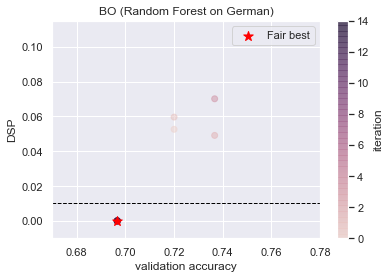

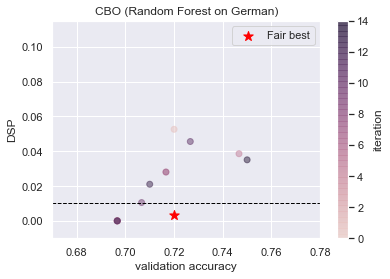

In [22]:
for method_name in ['BO', 'CBO']:
    if method_name == 'BO':
        df = results_df_standard
    else:
        df = results_df
    unfairness = list(df['constraint_metric'] + FAIRNESS_THRESHOLD)
    accuracies = list(1.0 - df['error'])
    ub = FAIRNESS_THRESHOLD
    scaling = 1
    best_acc = 0.0
    unf_best = 1.0
    for acc, unf in zip(accuracies, unfairness):
        if unf <= ub * scaling and acc > best_acc:
            best_acc = acc
            unf_best = unf
    cmap = sns.cubehelix_palette(as_cmap=True)
    f, ax = plt.subplots()
    points = ax.scatter(x=accuracies, y=unfairness, c=list(range(len(accuracies))), alpha=0.5, cmap=cmap)
    plt.scatter(best_acc, unf_best, color="red", marker='*', label='Fair best', s=100, alpha=1)
    plt.xlim(0.67, 0.78)
    plt.ylim(-0.01, 0.115)

    plt.legend(loc='upper right')
    plt.axhline(y=ub * scaling, xmin=0, xmax=1, color='black', linestyle='--', alpha=1, linewidth=1)

    f.colorbar(points, label='iteration')

    
    plt.xlabel('validation accuracy')

    plt.ylabel(f'DSP')
    algorithm_name = 'Random Forest'
    dataset_name = 'German'
    plt.title(f'{method_name} ({algorithm_name} on {dataset_name})')

In the plots above, the horizontal line is the fairness constraint,
set to DSP ≤ 0.01, and darker dots correspond to later BO iterations. Standard BO can get stuck in high-performing yet unfair
regions, failing to return a feasible solution. It is interesting to note how BO and CBO differently explore the search space. CBO is able to focus the exploration over the fair area of the hyperparameter space.

The presented method is model-agnostic and is able to handle any statistical notion of fairness. For instance, you can
repeat the experiments plugging in a constraint on DEO instead of DSP.